## Chapter 9 - Hierarchical Models

- [9.2.4 - Example: Therapeutic touch](#9.2.4---Example:-Therapeutic-touch)   
    - [Shrinkage](#Shrinkage)
- [9.5.1 - Example: Baseball batting abilities by position (subjects within categories)](#9.5.1---Example:-Baseball-batting-abilities-by-position)   

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline

plt.style.use('seaborn-white')
color = '#87ceeb'

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,pymc3,matplotlib,seaborn

pandas 0.23.4
numpy 1.15.0
pymc3 3.5
matplotlib 2.2.3
seaborn 0.9.0


### 9.2.4 - Example: Therapeutic touch

In [3]:
df = pd.read_csv('data/TherapeuticTouchData.csv', dtype={'s':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 2 columns):
y    280 non-null int64
s    280 non-null category
dtypes: category(1), int64(1)
memory usage: 2.8 KB


In [4]:
df.head()

,y,s
0,1,S01
1,0,S01
2,0,S01
3,0,S01
4,0,S01


#### Figure 9.9

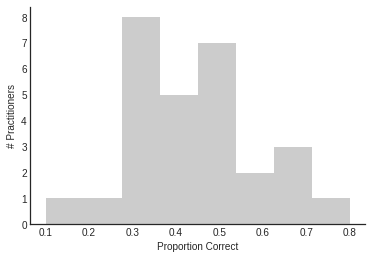

In [5]:
df_proportions = df.groupby('s')['y'].apply(lambda x: x.sum()/len(x))

ax = sns.distplot(df_proportions, bins=8, kde=False, color='gray')
ax.set(xlabel='Proportion Correct', ylabel='# Practitioners')
sns.despine(ax=ax);

#### Model (Kruschke, 2015)

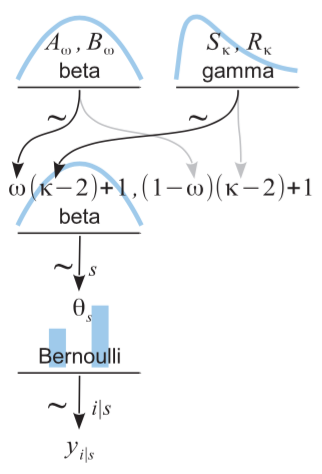

In [6]:
Image('images/fig9_7.png', width=200)

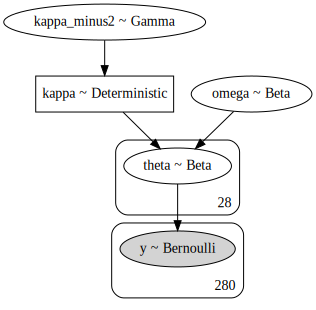

In [7]:
practitioner_idx = df.s.cat.codes.values
practitioner_codes = df.s.cat.categories
n_practitioners = practitioner_codes.size

with pm.Model() as hierarchical_model:
    omega = pm.Beta('omega', 1., 1.)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    theta = pm.Beta('theta', alpha=omega*(kappa-2)+1, beta=(1-omega)*(kappa-2)+1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)    

pm.model_to_graphviz(hierarchical_model)

In [8]:
with hierarchical_model:
    trace = pm.sample(5000, cores=4, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_minus2, omega]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:26<00:00, 829.85draws/s] 
The acceptance probability does not match the target. It is 0.9050607412038555, but should be close to 0.95. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


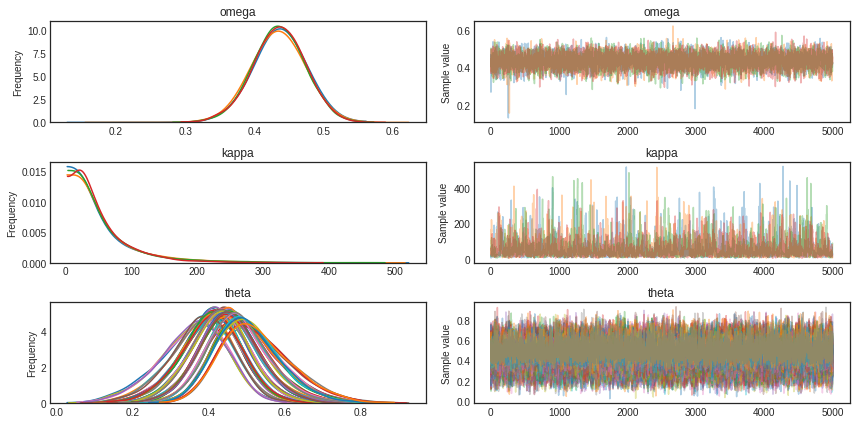

In [9]:
pm.traceplot(trace, ['omega','kappa', 'theta']);

In [10]:
pm.summary(trace)
# Note that theta is indexed starting with 0 and not 1, as is the case in Kruschke (2015).

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
omega,0.435352,0.037469,0.000435,0.361930,0.507949,6797.761232,1.000238
kappa_minus2,51.259617,52.123352,1.254601,1.873527,156.041840,1727.375582,1.000817
kappa,53.259617,52.123352,1.254601,3.873527,158.041840,1727.375537,1.000817
theta__0,0.358322,0.088953,0.001255,0.175670,0.523531,4544.174555,1.000122
theta__1,0.382073,0.084056,0.000941,0.209470,0.539493,7082.921387,1.000070
theta__2,0.406793,0.080257,0.000652,0.239386,0.560582,12771.483194,0.999905
theta__3,0.406775,0.081747,0.000727,0.234945,0.562970,13875.207839,1.000112
theta__4,0.405960,0.081271,0.000754,0.238028,0.563536,11553.752902,0.999945
theta__5,0.406151,0.080908,0.000745,0.233653,0.556640,11080.749737,0.999967
theta__6,0.406111,0.081066,0.000684,0.233887,0.557927,12251.026112,0.999922


#### Figure 9.10 - Marginal posterior distributions

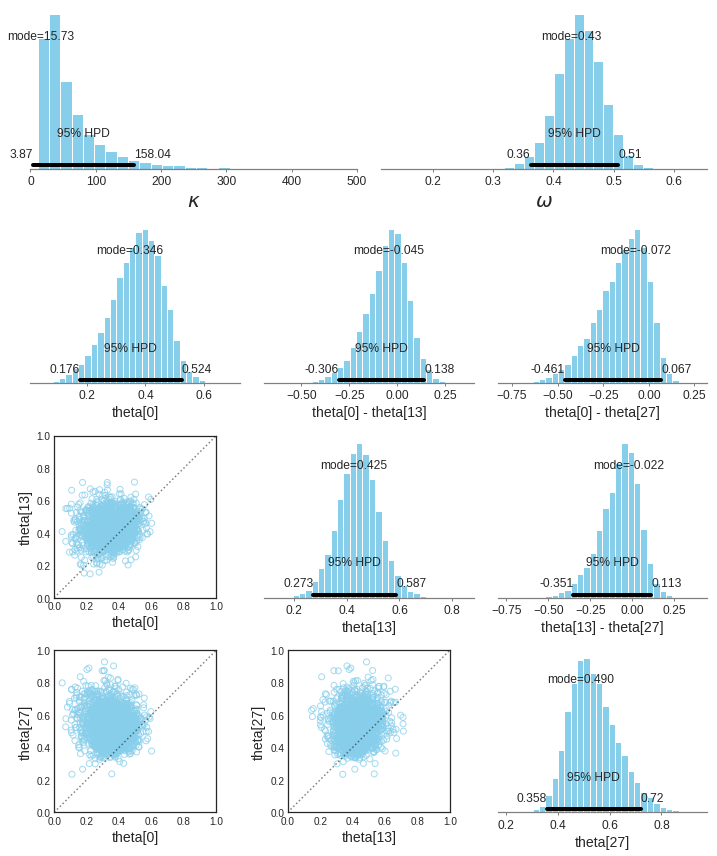

In [11]:
plt.figure(figsize=(10,12))

# Define gridspec
gs = gridspec.GridSpec(4, 6)
ax1 = plt.subplot(gs[0,:3])
ax2 = plt.subplot(gs[0,3:])
ax3 = plt.subplot(gs[1,:2])
ax4 = plt.subplot(gs[1,2:4])
ax5 = plt.subplot(gs[1,4:6])
ax6 = plt.subplot(gs[2,:2])                     
ax7 = plt.subplot(gs[2,2:4])
ax8 = plt.subplot(gs[2,4:6])
ax9 = plt.subplot(gs[3,:2])
ax10 = plt.subplot(gs[3,2:4])
ax11 = plt.subplot(gs[3,4:6])

# thetas and theta pairs to plot
thetas = (0, 13, 27)
theta_pairs = ((0,13),(0,27),(13,27))

font_d = {'size':14}

# kappa & omega posterior plots
for var, ax in zip(['kappa', 'omega'], [ax1, ax2]):
    pm.plot_posterior(trace[var], point_estimate='mode', ax=ax, color=color, round_to=2)
    ax.set_xlabel('$\{}$'.format(var), fontdict={'size':20, 'weight':'bold'})
ax1.set(xlim=(0,500))

# theta posterior plots
for var, ax in zip(thetas,[ax3, ax7, ax11]):
    pm.plot_posterior(trace['theta'][:,var], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}]'.format(var), fontdict=font_d)

# theta scatter plots
for var, ax in zip(theta_pairs,[ax6, ax9, ax10]):
    ax.scatter(trace['theta'][::10,var[0]], trace['theta'][::10,var[1]], alpha=0.75, color=color, facecolor='none')
    ax.plot([0, 1], [0, 1], ':k', transform=ax.transAxes, alpha=0.5)
    ax.set_xlabel('theta[{}]'.format(var[0]), fontdict=font_d)
    ax.set_ylabel('theta[{}]'.format(var[1]), fontdict=font_d)
    ax.set(xlim=(0,1), ylim=(0,1), aspect='equal')

# theta posterior differences plots
for var, ax in zip(theta_pairs,[ax4, ax5, ax8]):
    pm.plot_posterior(trace['theta'][:,var[0]]-trace['theta'][:,var[1]], point_estimate='mode', ax=ax, color=color)
    ax.set_xlabel('theta[{}] - theta[{}]'.format(*var), fontdict=font_d)

plt.tight_layout()

### Shrinkage

Let's create a model with just the theta estimations per practitioner, without the influence of a higher level distribution. Then we can compare the theta values with the hierarchical model above.

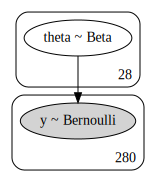

In [12]:
with pm.Model() as unpooled_model:
    
    theta = pm.Beta('theta', 1, 1, shape=n_practitioners)
        
    y = pm.Bernoulli('y', theta[practitioner_idx], observed=df.y)
    
pm.model_to_graphviz(unpooled_model)

In [13]:
with unpooled_model:
    unpooled_trace = pm.sample(5000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:07<00:00, 3095.91draws/s]


Here we concatenate the trace results (thetas) from both models into a dataframe. Next we shape the data into a format that we can use with Seaborn's pointplot.

In [14]:
df_shrinkage = (pd.concat([pm.summary(unpooled_trace).iloc[:,0],
                           pm.summary(trace).iloc[3:,0]],
                          axis=1)
                .reset_index())
df_shrinkage.columns = ['theta', 'unpooled', 'hierarchical']
df_shrinkage = pd.melt(df_shrinkage, 'theta', ['unpooled', 'hierarchical'], var_name='Model')
df_shrinkage.head()

,theta,Model,value
0,theta__0,unpooled,0.166819
1,theta__1,unpooled,0.249644
2,theta__2,unpooled,0.334258
3,theta__3,unpooled,0.333547
4,theta__4,unpooled,0.333647


The below plot shows that the theta estimates on practitioner level are pulled towards the group mean of the hierarchical model.

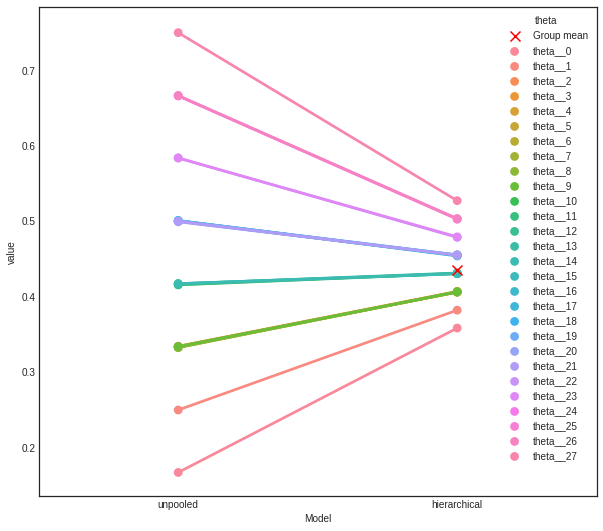

In [15]:
plt.figure(figsize=(10,9))
plt.scatter(1, pm.summary(trace).iloc[0,0], s=100, c='r', marker='x', zorder=999, label='Group mean')
sns.pointplot(x='Model', y='value', hue='theta', data=df_shrinkage);

### 9.5.1 - Example: Baseball batting abilities by position

In [16]:
df2 = pd.read_csv('data/BattingAverage.csv', usecols=[0,1,2,3], dtype={'PriPos':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
Player    948 non-null object
PriPos    948 non-null category
Hits      948 non-null int64
AtBats    948 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 23.6+ KB


The DataFrame contains records for 948 players in the 2012 regular season of Major League Baseball.
- One record per player
- 9 primary field positions

In [17]:
df2['BatAv'] = df2.Hits.divide(df2.AtBats)
df2.head(10)

,Player,PriPos,Hits,AtBats,BatAv
0,Fernando Abad,Pitcher,1,7,0.142857
1,Bobby Abreu,Left Field,53,219,0.242009
2,Tony Abreu,2nd Base,18,70,0.257143
3,Dustin Ackley,2nd Base,137,607,0.225700
4,Matt Adams,1st Base,21,86,0.244186
5,Nathan Adcock,Pitcher,0,1,0.000000
6,Jeremy Affeldt,Pitcher,0,1,0.000000
7,Brandon Allen,1st Base,2,20,0.100000
8,Yonder Alonso,1st Base,150,549,0.273224
9,Jose Altuve,2nd Base,167,576,0.289931


In [18]:
# Batting average by primary field positions calculated from the data
df2.groupby('PriPos')['Hits','AtBats'].sum().pipe(lambda x: x.Hits/x.AtBats)

PriPos
1st Base        0.258851
2nd Base        0.255676
3rd Base        0.265036
Catcher         0.247404
Center Field    0.263513
Left Field      0.259077
Pitcher         0.129148
Right Field     0.263555
Shortstop       0.255186
dtype: float64

#### Model (Kruschke, 2015)

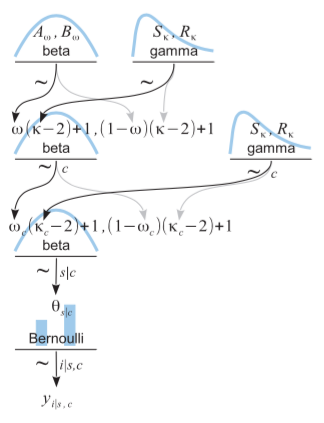

In [19]:
Image('images/fig9_13.png', width=300)

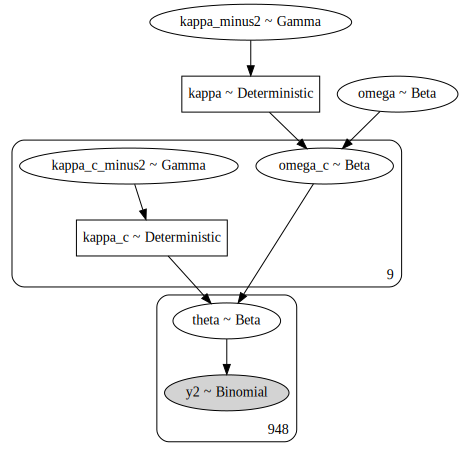

In [20]:
pripos_idx = df2.PriPos.cat.codes.values
pripos_codes = df2.PriPos.cat.categories
n_pripos = pripos_codes.size

# df2 contains one entry per player
n_players = df2.index.size

with pm.Model() as hierarchical_model2:
    # Hyper parameters
    omega = pm.Beta('omega', 1, 1)
    kappa_minus2 = pm.Gamma('kappa_minus2', 0.01, 0.01)
    kappa = pm.Deterministic('kappa', kappa_minus2 + 2)
    
    # Parameters for categories (Primary field positions)
    omega_c = pm.Beta('omega_c',
                       omega*(kappa-2)+1, (1-omega)*(kappa-2)+1,
                       shape = n_pripos)
    
    kappa_c_minus2 = pm.Gamma('kappa_c_minus2',
                              0.01, 0.01,
                              shape = n_pripos)
    kappa_c = pm.Deterministic('kappa_c', kappa_c_minus2 + 2)
        
    # Parameter for individual players
    theta = pm.Beta('theta',
                     omega_c[pripos_idx]*(kappa_c[pripos_idx]-2)+1,
                    (1-omega_c[pripos_idx])*(kappa_c[pripos_idx]-2)+1,
                     shape = n_players)
    
    y2 = pm.Binomial('y2', n=df2.AtBats.values, p=theta, observed=df2.Hits)

pm.model_to_graphviz(hierarchical_model2)

In [ ]:
with hierarchical_model2:
    trace2 = pm.sample(3000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, kappa_c_minus2, omega_c, kappa_minus2, omega]
Sampling 4 chains:  70%|███████   | 9821/14000 [01:29<00:39, 105.09draws/s]

In [ ]:
pm.traceplot(trace2, ['omega', 'kappa', 'omega_c', 'kappa_c']);

#### Figure 9.17

#### Posterior distribution of hyper parameter omega after sampling.

In [ ]:
pm.plot_posterior(trace2['omega'], point_estimate='mode', color=color)
plt.title('Overall', fontdict={'fontsize':16, 'fontweight':'bold'})
plt.xlabel('omega', fontdict={'fontsize':14});

#### Posterior distributions of the omega_c parameters after sampling.

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(14,8))

for i, ax in enumerate(axes.T.flatten()):
    pm.plot_posterior(trace2['omega_c'][:,i], ax=ax, point_estimate='mode', color=color)
    ax.set_title(pripos_codes[i], fontdict={'fontsize':16, 'fontweight':'bold'})
    ax.set_xlabel('omega_c__{}'.format(i), fontdict={'fontsize':14})
    ax.set_xlim(0.10,0.30)

plt.tight_layout(h_pad=3)